# Decision Trees

Decision trees are a straightforward model type that is the basis for some of the most powerful models in machine learning.

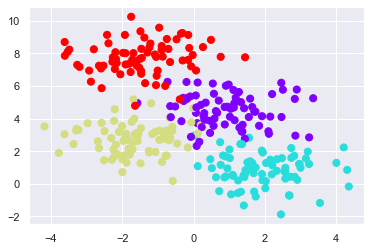

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs
sns.set()

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow');

<ipython-input-2-4236fcd02cda>:23: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


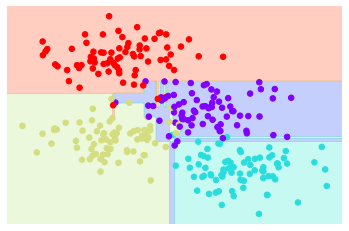

In [2]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    
visualize_classifier(DecisionTreeClassifier(), X, y);

### overfitting

Overfitting is a fundamental property of decision trees.

The key intuition to make these types of models better is to use **many bad models** rather than one strong one.

# Random Forests

Multiple overfitting estimators can be combined to average out into a good prediction. This is called **bagging**

Bagging makes use of an ensemble of parallel estimators, each of which over-fits the data, and averages the results to find a better classification.

An ensemble of randomized decision trees is known as a *random forest*.

This type of bagging classification can be done manually using Scikit-Learn's ``BaggingClassifier`` meta-estimator, as shown here:

<ipython-input-2-4236fcd02cda>:23: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


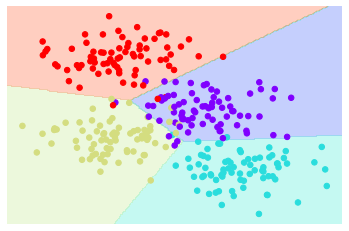

In [3]:
# Bagging other type of models
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
bag = BaggingClassifier(lgr, n_estimators=100, max_samples=0.8,
                        random_state=1)

bag.fit(X, y)
visualize_classifier(bag, X, y)

<ipython-input-2-4236fcd02cda>:23: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


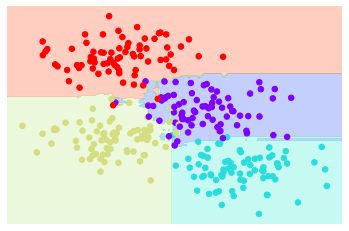

In [4]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

# Gradient Boosted Decision Trees

The most popular libraries in this class of models are LightGBM, XGBoost and CatBoost.

These models are extremely popular because they are both powerful and fast to train. LightGBM is in fact the most used library in winning submissions on Kaggle!

LightGBM supports random forests as well, but GBDTs are the most interesting one.

GBDTs are similar to random forests, except they train trees one after the other, minimizing the **residual loss** (the difference between predicted quantities up to now and target) on each step.

[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
<ipython-input-2-4236fcd02cda>:23: UserWarning: The following kwargs were not used by contour: 'clim'
  contours = ax.contourf(xx, yy, Z, alpha=0.3,


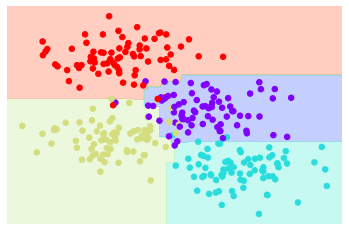

In [5]:
import lightgbm as lgbm

model = lgbm.LGBMClassifier(
    # goss (faster), gbdt (reliable), dart (accurate)
    boosting_type='goss', 
    # most important params
    num_leaves=15,
    max_depth=-1,
    n_estimators=20,
    # other params
    learning_rate=0.1,
    bagging_fraction=0.8,
    #bagging_freq=0
)
visualize_classifier(model, X, y);

One disadvantage of GBDT models is that they have **many, many settings**. [Here](https://lightgbm.readthedocs.io/en/latest/Parameters.html) is a page going over them. [here](https://neptune.ai/blog/lightgbm-parameters-guide) is a good resource on tuning them.

In practice, you generally end up aggressively gridsearching over GBDTs.

# Interpretation with Shapley values

This is an introduction to explaining machine learning models with Shapley values. Shapley values are a widely used approach from cooperative game theory that come with desirable properties. This tutorial is designed to help build a solid understanding of how to compute and interpet Shapley-based explanations of machine learning models. We will take a practical hands-on approach, using the `shap` Python package to explain progressively more complex models. This is a living document, and serves as an introduction to the `shap` Python package. So if you have feedback or contributions please open an issue or pull request to make this tutorial better!

In [1]:
import pandas as pd
import sklearn
import shap

# a classic housing price dataset
X, y = shap.datasets.boston()
X100 = shap.sample(X, 100) # 100 instances for use as the background distribution

# a simple linear model
model = sklearn.linear_model.LinearRegression()
model.fit(X, y)

print("Model coefficients:\n")
for i in range(X.shape[1]):
    print(X.columns[i], "=", model.coef_[i].round(4))

Model coefficients:

CRIM = -0.108
ZN = 0.0464
INDUS = 0.0206
CHAS = 2.6867
NOX = -17.7666
RM = 3.8099
AGE = 0.0007
DIS = -1.4756
RAD = 0.306
TAX = -0.0123
PTRATIO = -0.9527
B = 0.0093
LSTAT = -0.5248


## Explaining an additive regression model

<a id="additive_regression"></a>

The reason the partial dependence plots of linear models have such a close connection to SHAP values is because each feature in the model is handled independently of every other feature (the effects are just added together). We can keep this additive nature while relaxing the linear requirement of straight lines. This results in the well-known class of generalized additive models (GAMs). While there are many ways to train these types of models (like setting an XGBoost model to depth-1), we will use InterpretMLs explainable boosting machines that are specifically designed for this.

In [2]:
import lightgbm as lgbm
model_ebm = lgbm.LGBMRegressor()
model_ebm.fit(X, y)

# explain the GAM model with SHAP
explainer_ebm = shap.Explainer(model_ebm)
shap_values_ebm = explainer_ebm(X)

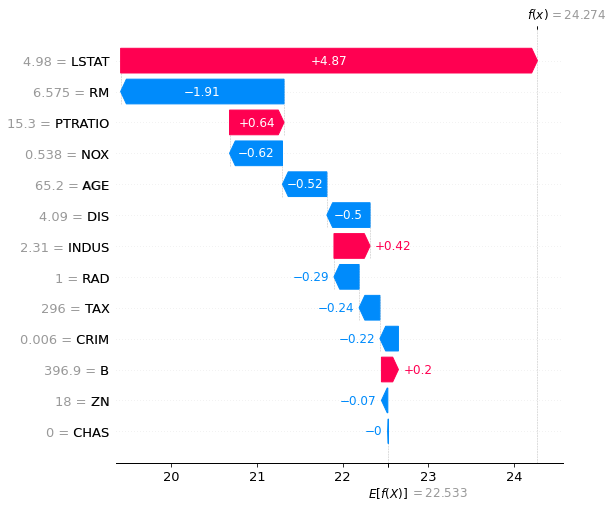

In [4]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.waterfall(shap_values_ebm[0], max_display=14)

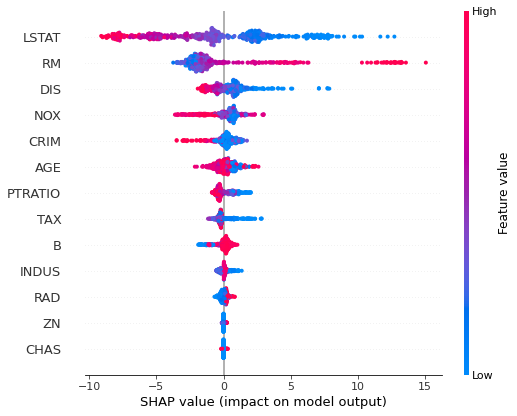

In [5]:
# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.plots.beeswarm(shap_values_ebm, max_display=14)